In [2]:
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from Image_Functions import slicing, crop_images_to_brain, crop_to_size
from datasetModule import Set
from Model import CNN

Most of the functionallity is stored in module files. 
The data consist of Images with 3 channels and segmentation images with 2 channels.


In [3]:
"Need to specify the local path on computer"
dir_path = "../Task3/"

In [4]:
'Splitting the data into 30% test and 70% training.'
X_train, X_test = train_test_split(Set(dir_path, sub_dir = 'sub-20'), test_size=0.3, random_state=25)

../Task3/sub-208
../Task3/sub-209
../Task3/sub-206
../Task3/sub-203
../Task3/sub-207
../Task3/sub-205
../Task3/sub-204
../Task3/sub-201
../Task3/sub-202


In [5]:
X_train_c, X_test_c = crop_images_to_brain(X_train), crop_images_to_brain(X_test)
size = (256,288,176)
X_train_c, X_test_c = crop_to_size(X_train_c, size), crop_to_size(X_test_c,size)

6
torch.Size([3, 269, 322, 173])
torch.Size([3, 269, 322, 173])
torch.Size([3, 269, 322, 173])
torch.Size([3, 269, 322, 173])
torch.Size([3, 269, 322, 173])
torch.Size([3, 269, 322, 173])
3
torch.Size([3, 279, 340, 167])
torch.Size([3, 279, 340, 167])
torch.Size([3, 279, 340, 167])
torch.Size([3, 256, 288, 176])
torch.Size([2, 256, 288, 176])
torch.Size([3, 256, 288, 176])
torch.Size([2, 256, 288, 176])
torch.Size([3, 256, 288, 176])
torch.Size([2, 256, 288, 176])
torch.Size([3, 256, 288, 176])
torch.Size([2, 256, 288, 176])
torch.Size([3, 256, 288, 176])
torch.Size([2, 256, 288, 176])
torch.Size([3, 256, 288, 176])
torch.Size([2, 256, 288, 176])
torch.Size([3, 256, 288, 176])
torch.Size([2, 256, 288, 176])
torch.Size([3, 256, 288, 176])
torch.Size([2, 256, 288, 176])
torch.Size([3, 256, 288, 176])
torch.Size([2, 256, 288, 176])


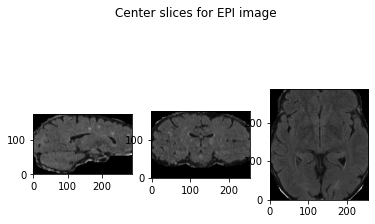

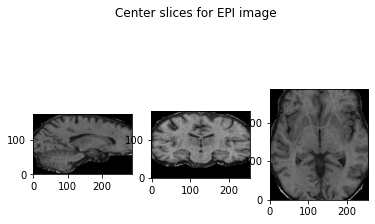

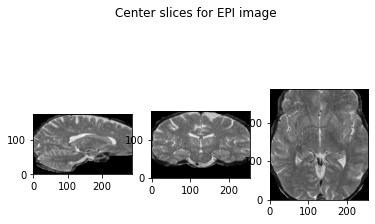

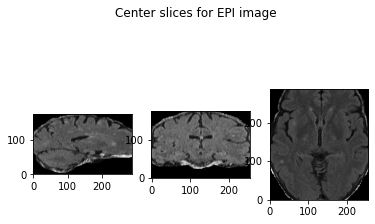

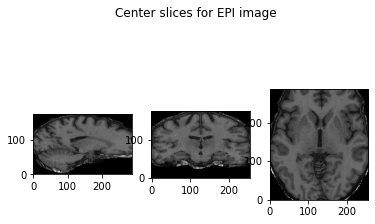

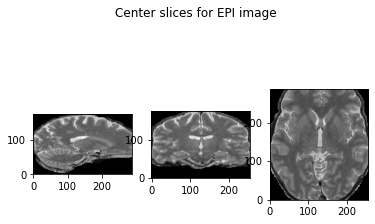

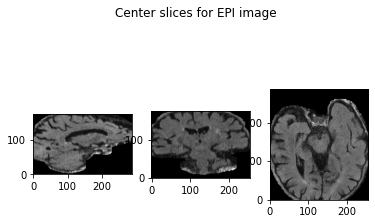

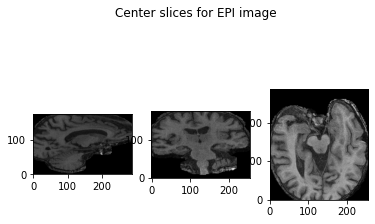

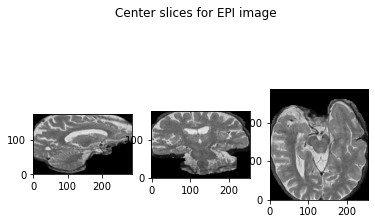

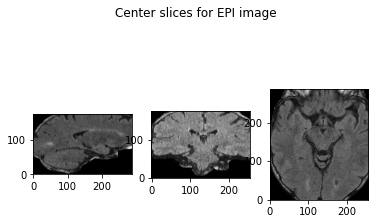

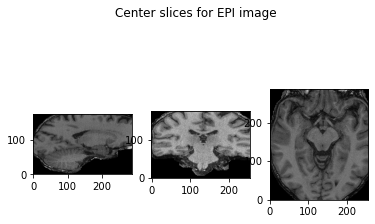

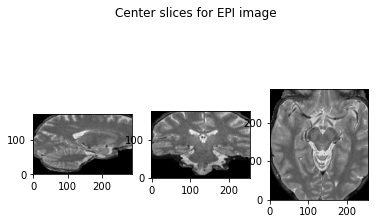

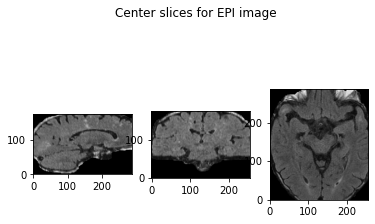

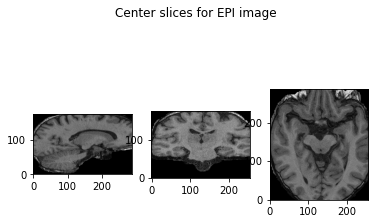

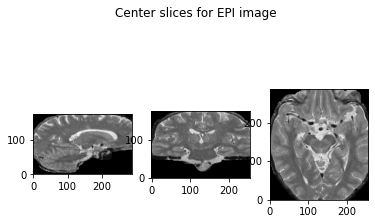

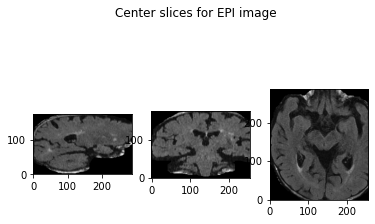

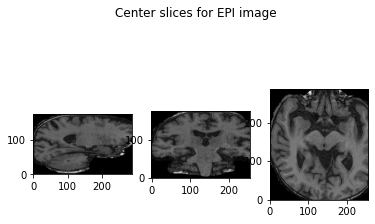

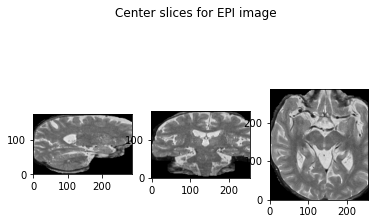

In [6]:
'Visualising slices of images along all three axis'
for i in range(len(X_train_c)):
    for j in range(3):
        img = X_train_c[i]['data'][j]
        img = img.float()
        slicing(img)

In order to access the set after they have been parsed through the dataloader:


To access a batch: batch = next(iter(<<Insert name here>>))


To access the data: batch['batchnumber']['data']


To access the segmentation: batch['batchnumber']['seg]

In [7]:
'Load training and test set, batch size may vary'
train_set, test_set = DataLoader(X_train_c, batch_size=2), DataLoader(X_test_c, batch_size=1)

In [8]:
tmp = next(iter(train_set))
image = tmp['data']
print(image.shape)
print(type(image))

torch.Size([2, 3, 256, 288, 176])
<class 'torch.Tensor'>


In [9]:
'Run the CNN'
model = CNN()
out_img = model(image)
print(out_img.shape)

1st convolution
torch.Size([2, 16, 256, 288, 176])
torch.Size([2, 32, 256, 288, 176])


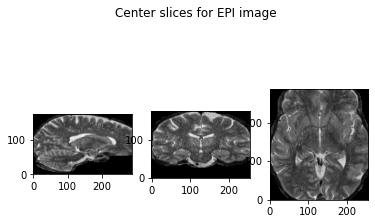

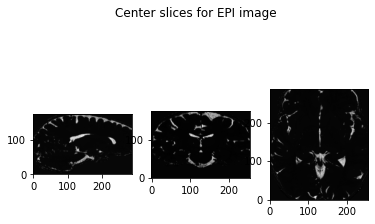

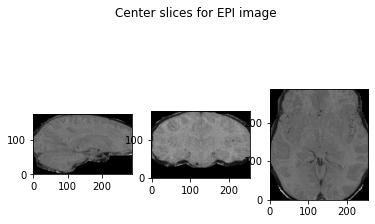

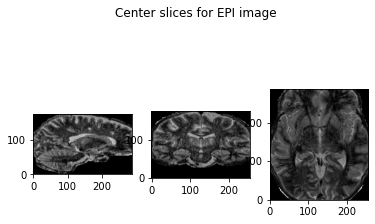

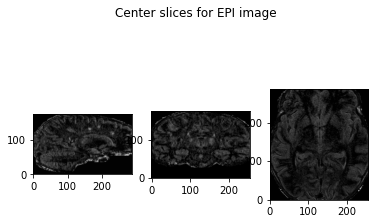

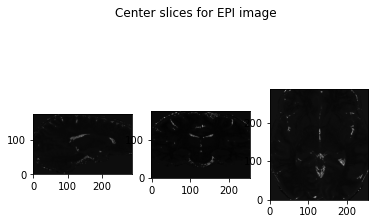

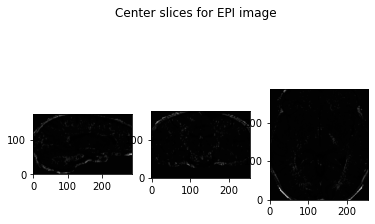

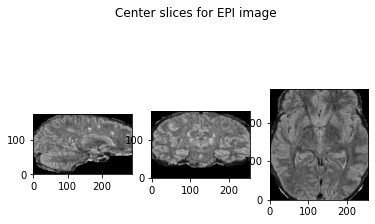

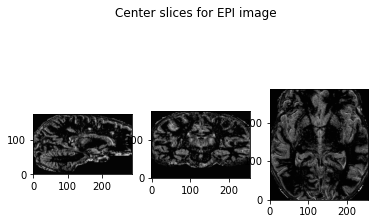

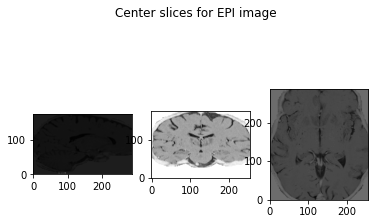

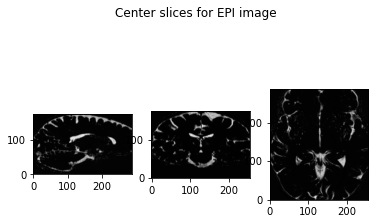

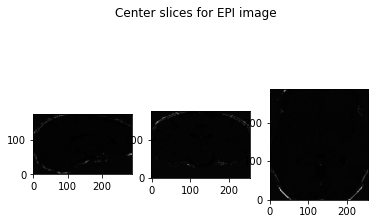

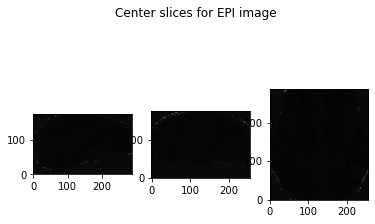

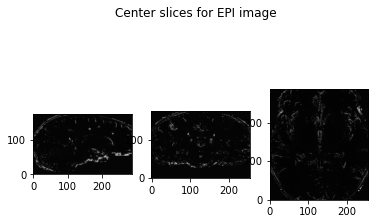

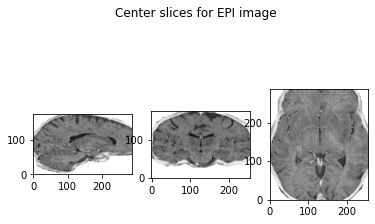

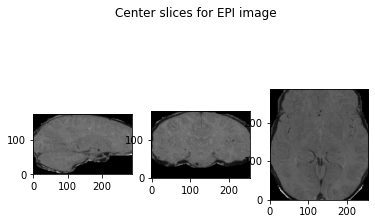

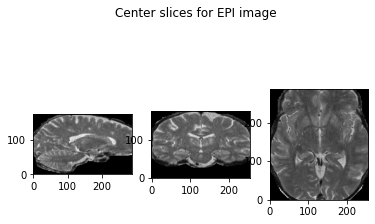

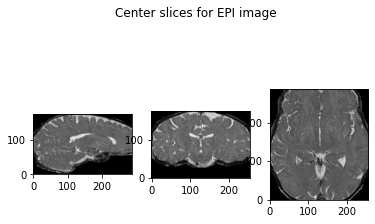

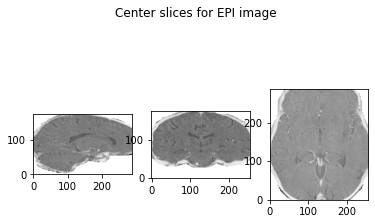

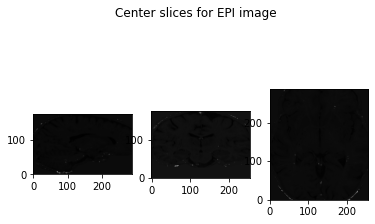

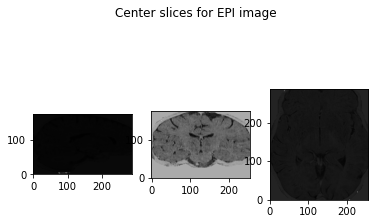

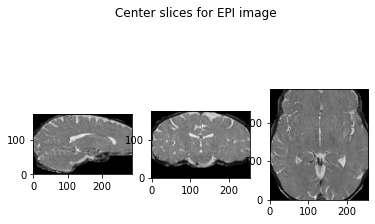

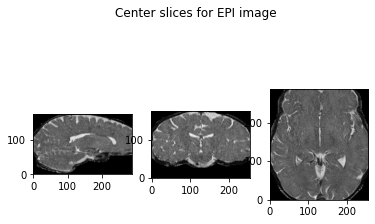

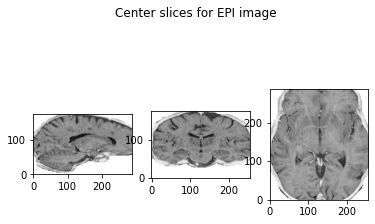

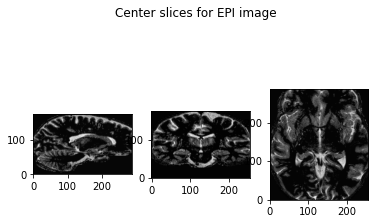

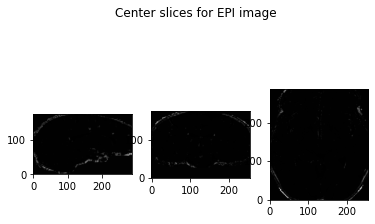

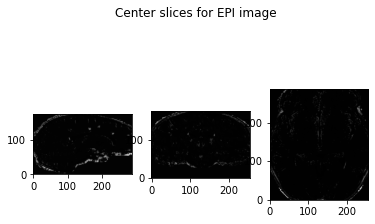

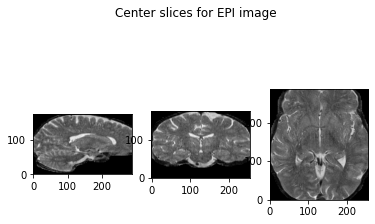

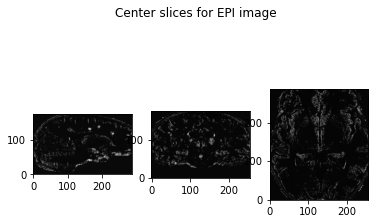

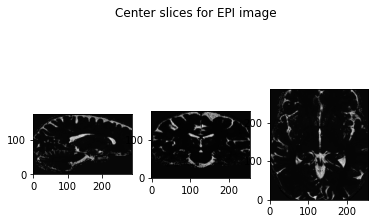

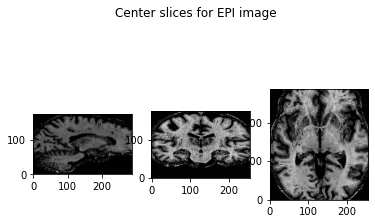

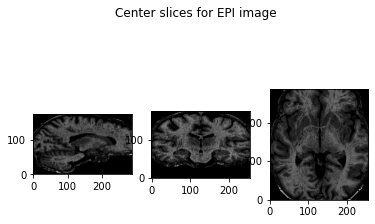

In [10]:
'Visualise all channels of a convolution layer'
img_arr = out_img.detach().numpy()
for i in range(len(img_arr[0])):
    slicing(img_arr[0][i])